# Active Learning

# Import Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from lightning import pytorch as pl

from chemprop import data, featurizers, models, nn
import random

from typing import Tuple
from torch.utils.data import DataLoader

# Change data inputs

In [4]:
chemprop_dir = Path.cwd().parent
input_path = chemprop_dir / "tests" / "data" / "regression" / "mol" / "mol.csv" # path to your data .csv file
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
smiles_column = 'smiles' # name of the column containing SMILES strings
target_columns = ['lipo'] # list of names of the columns containing targets

## Load data

In [5]:
df_input = pd.read_csv(input_path)
df_input

,smiles,lipo
0,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54
1,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18
2,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69
3,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37
4,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10
...,...,...
95,CC(C)N(CCCNC(=O)Nc1ccc(cc1)C(C)(C)C)C[C@H]2O[C...,2.20
96,CCN(CC)CCCCNc1ncc2CN(C(=O)N(Cc3cccc(NC(=O)C=C)...,2.04
97,CCSc1c(Cc2ccccc2C(F)(F)F)sc3N(CC(C)C)C(=O)N(C)...,4.49
98,COc1ccc(Cc2c(N)n[nH]c2N)cc1,0.20


## Get SMILES and targets

In [6]:
smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values

In [7]:
smis[:5] # show first 5 SMILES strings

array(['Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14',
       'COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23',
       'COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl',
       'OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3',
       'Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)NCC#N)c1'],
      dtype=object)

In [8]:
ys[:5] # show first 5 targets

array([[ 3.54],
       [-1.18],
       [ 3.69],
       [ 3.37],
       [ 3.1 ]])

## Get molecule datapoints

In [9]:
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]

## Data splitting for training/validation pool and testing

In [10]:
# available split types
list(data.SplitType.keys())

['CV_NO_VAL',
 'CV',
 'SCAFFOLD_BALANCED',
 'RANDOM_WITH_REPEATED_SMILES',
 'RANDOM',
 'KENNARD_STONE',
 'KMEANS']

In [11]:
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
nontest_indices, _, test_indices = data.make_split_indices(mols, "random", (0.9, 0.0, 0.1))
nontest_data, _, test_data = data.split_data_by_indices(
    all_data, nontest_indices, None, test_indices
)

## Get featurizer

In [12]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

## Get scaler

In [13]:
nontest_dset = data.MoleculeDataset(nontest_data, featurizer)
scaler = nontest_dset.normalize_targets()

## Batch norm

In [14]:
batch_norm = True

# Change model inputs here

In [15]:
def get_mpnn():
    output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
    ffn = nn.RegressionFFN(output_transform=output_transform)

    metric_list = [nn.metrics.RMSEMetric(), nn.metrics.MAEMetric()]
    mpnn = models.MPNN(nn.BondMessagePassing(), nn.MeanAggregation(), ffn, batch_norm, metric_list)

    return mpnn

get_mpnn()

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSELoss(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
)

# Change active learning parameters here

In [17]:
query_size = len(nontest_data) // 8  # number of new datapoints added to trainval pool each iteration.

train_sizes = list(range(query_size, len(nontest_data) + 1, query_size))  # size of trainval datapool for each interval.
train_sizes[-1] = len(nontest_data)  # include all data in last iteration.

In [18]:
# a priority function can be defined to control the order in which datapoints are added to the training and validation pool.
def priority_function(mpnn, mol):
    return random.random()

    # in v2.1, uncertainty can be used as a good choice of priority function.

## Getting dataloaders

In [20]:
def get_dataloaders() -> Tuple[DataLoader]:
    trainval_mols = [d.mol for d in trainval_data]  # RDkit Mol objects are use for structure based splits
    train_indices, _, val_indices = data.make_split_indices(trainval_mols, "random", (0.9, 0.0, 0.1))
    train_data, val_data, _ = data.split_data_by_indices(
        trainval_data, train_indices, val_indices, None
    )

    train_dset = data.MoleculeDataset(train_data, featurizer)
    train_dset.normalize_targets(scaler)

    val_dset = data.MoleculeDataset(val_data, featurizer)
    val_dset.normalize_targets(scaler)

    test_dset = data.MoleculeDataset(test_data, featurizer)

    train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
    val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
    test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)
    return train_loader, val_loader, test_loader

# Train with active learning

## Set up trainer

In [39]:
def get_trainer():
    return pl.Trainer(
        logger=False,
        enable_checkpointing=True,  # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
        enable_progress_bar=False,
        accelerator="cpu",
        devices=1,
        max_epochs=20,  # number of epochs to train for
    )

## Start training

In [53]:
trainval_data = []
remaining_data = nontest_data
al_results = []

mpnn = get_mpnn()
for train_size in train_sizes:
    # sort new datapoints by priority using priority function
    priority_remaining_data = [(priority_function(mpnn, d), d) for d in remaining_data]
    sorted_remaining_data = [d[1] for d in sorted(priority_remaining_data, reverse=True)] 
    new_size = train_size - len(trainval_data)

    new_data = sorted_remaining_data[:new_size]
    remaining_data = remaining_data[new_size:]

    trainval_data.extend(new_data)

    train_loader, val_loader, test_loader = get_dataloaders()
    trainer = get_trainer()
    
    mpnn = get_mpnn()  # remove this line to continue training from the previous model
    trainer.fit(mpnn, train_loader, val_loader)
    
    result = trainer.test(mpnn, test_loader)  # intermediate results can be used for early stopping
    al_results.append((train_size, result[0]['batch_averaged_test/rmse']))

/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.90, got 0.82. Requested test size of 0.10, got 0.18. 
  warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/joelmanu/chemprop/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

  | Name            | Type               | Params
-------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K 
1 | agg             | MeanAggregation    | 0     
2 | bn      

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.7469680905342102
batch_averaged_test/rmse    1.0287398099899292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=20` reached.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.90, got 0.88. Requested test size of 0.10, got 0.12. 
  warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/joelmanu/anaconda3/envs/ch

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.8071862459182739
batch_averaged_test/rmse    1.0669500827789307
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=20` reached.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.90, got 0.89. Requested test size of 0.10, got 0.11. 
  warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/joelmanu/anaconda3/envs/ch

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.8069214820861816
batch_averaged_test/rmse    1.0667847394943237
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=20` reached.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.90, got 0.89. Requested test size of 0.10, got 0.11. 
  warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/joelmanu/anaconda3/envs/ch

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.7309015393257141
batch_averaged_test/rmse     1.010951042175293
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=20` reached.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.90, got 0.89. Requested test size of 0.10, got 0.11. 
  warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/joelmanu/anaconda3/envs/ch

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.7700172662734985
batch_averaged_test/rmse    1.0316932201385498
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=20` reached.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/joelmanu/chemprop/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/Users/joelmanu/anac

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.7075433731079102
batch_averaged_test/rmse    0.9940563440322876
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=20` reached.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/joelmanu/chemprop/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/Users/joelmanu/anac

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.8526906967163086
batch_averaged_test/rmse    1.1250193119049072
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


`Trainer.fit` stopped: `max_epochs=20` reached.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 batch_averaged_test/mae    0.8096640706062317
batch_averaged_test/rmse    1.0935723781585693
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Users/joelmanu/anaconda3/envs/chv2/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


In [54]:
al_results

[(11, 1.0287398099899292),
 (22, 1.0669500827789307),
 (33, 1.0667847394943237),
 (44, 1.010951042175293),
 (55, 1.0316932201385498),
 (66, 0.9940563440322876),
 (77, 1.1250193119049072),
 (90, 1.0935723781585693)]

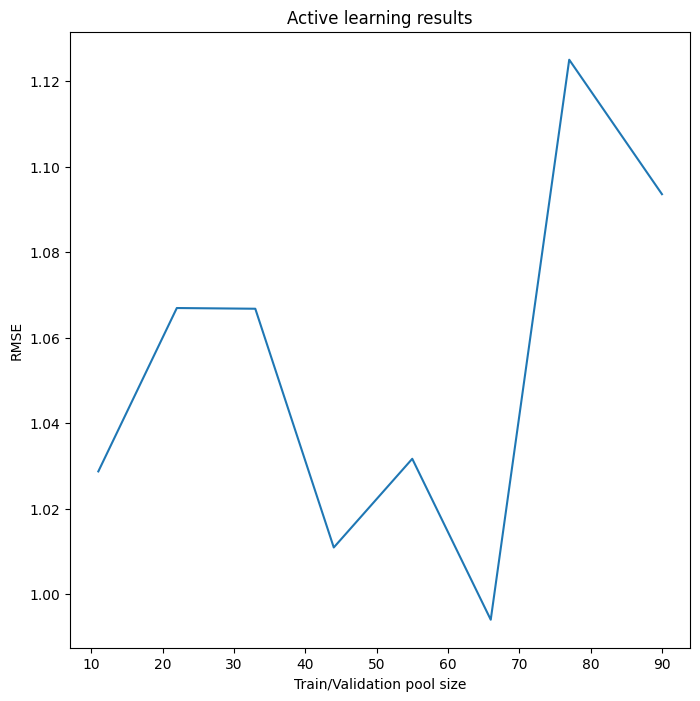

In [55]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Active learning results")
ax.set_xlabel('Train/Validation pool size'); ax.set_ylabel('RMSE')

ax.plot([a[0] for a in al_results], [a[1] for a in al_results])
plt.show()